# Example of creating and running a Parallel Tempered Sampler

In this notebook we will setup a sampler to sample a 2D Gaussian distribution with mean $\bar{x} = 2, \bar{y} = 5$ and variance $\sigma_x^2 = 1$, $\sigma_y^2 = 2$; $\sigma^2_{xy} = \sigma^2_{yx} = 0$, using a prior that is uniform over $x, y \in [-20, 20)$.

We will sample the space with 12 chains, each of which has 3 tempertures. We will use Python's multiprocessing to parallelize running over 4 cores. We then demonstrate how to extract results, as well as how to resume a sampler from a saved state.

In [1]:
%matplotlib notebook
from __future__ import print_function
from matplotlib import pyplot
import numpy
import randomgen

import epsie
from epsie import make_betas_ladder
from epsie.samplers import ParallelTemperedSampler
import multiprocessing

## Create the model to sample

***Note:*** Below we create a class with several functions to draw samples from the prior and to evaluate the log posterior. This isn't strictly necessary. The only thing the Sampler really requires is a function that it can pass keyword arguments to and get back a tuple of (log likelihood, log prior). However, setting things up as a class will make it convenient to, e.g., draw random samples from the prior for the starting positiions, as well as plot the model later on.

In [2]:
from scipy import stats
class Model(object):
    def __init__(self):
        # we'll use a 2D Gaussian for the likelihood distribution
        self.params = ['x', 'y']
        self.mean = [2., 5.]
        self.cov = [[1., 0.], [0., 2.]]
        self.likelihood_dist = stats.multivariate_normal(mean=self.mean,
                                                         cov=self.cov)

        # we'll just use a uniform prior
        self.prior_bounds = {'x': (-20., 20.),
                             'y': (-20., 20.)}
        xmin = self.prior_bounds['x'][0]
        dx = self.prior_bounds['x'][1] - xmin
        ymin = self.prior_bounds['y'][0]
        dy = self.prior_bounds['y'][1] - ymin
        self.prior_dist = {'x': stats.uniform(xmin, dx),
                           'y': stats.uniform(ymin, dy)}

    def prior_rvs(self, size=None, shape=None):
        return {p: self.prior_dist[p].rvs(size=size).reshape(shape)
                for p in self.params}
    
    def logprior(self, **kwargs):
        return sum([self.prior_dist[p].logpdf(kwargs[p]) for p in self.params])
    
    def loglikelihood(self, **kwargs):
        return self.likelihood_dist.logpdf([kwargs[p] for p in self.params])
    
    def __call__(self, **kwargs):
        logp = self.logprior(**kwargs)
        if logp == -numpy.inf:
            logl = None
        else:
            logl = self.loglikelihood(**kwargs)
        return logl, logp

In [3]:
model = Model()

## Setup and run the sampler

Create a pool of 4 parallel processes, then initialize the sampler using the model we created above.

In [4]:
nchains = 12
ntemps = 3
nprocs = 4
pool = multiprocessing.Pool(nprocs)

betas = make_betas_ladder(ntemps, 1e5)
sampler = ParallelTemperedSampler(model.params, model, nchains, betas=betas, pool=pool)

Now set the starting positions of the chains by drawing random variates from the model's prior.

In [5]:
sampler.set_start(model.prior_rvs(size=nchains*ntemps, shape=(nchains, ntemps)))

### Let's run it!

This will evolve each chain in the collection by 250 steps. This is parallelized over the pool of processes.

In [6]:
sampler.run(250)

## Extract results

We can get the history of all of the chains using the `.positions` attribute. This will return a numpy structured array in which the fields are the parameters names (in this case, `'x'` and `'y'`), and with shape `ntemps x nchains x niterations`:

In [7]:
positions = sampler.positions
print('sampler.positions: {}'.format(type(positions)))
print('with fields: {}'.format(positions.dtype.names))
print('and shape:', positions.shape)

sampler.positions: <type 'numpy.ndarray'>
with fields: ('x', 'y')
and shape: (3, 12, 250)


This (or any structured array returned by epsie) can be turned into a dictionary of arrays, where the keys are the parameter names, using `epsie.array2dict`:

In [8]:
positions = epsie.array2dict(sampler.positions)
print('sampler.positions: {} with keys/values:'.format(type(positions)))
for param in sorted(positions):
    print('"{}": {} with shape {}'.format(param, type(positions[param]), positions[param].shape))

sampler.positions: <type 'dict'> with keys/values:
"x": <type 'numpy.ndarray'> with shape (3, 12, 250)
"y": <type 'numpy.ndarray'> with shape (3, 12, 250)


We can also access the history of log likelihoods and log priors using `sampler.stats`, as well as the acceptance ratios and which jumps were accepted with `sampler.acceptance`:

In [9]:
stats = sampler.stats
print('sampler.stats: {}'.format(type(positions)))
print('with fields: {}'.format(stats.dtype.names))
print('and shape:', stats.shape)

sampler.stats: <type 'dict'>
with fields: ('logl', 'logp')
and shape: (3, 12, 250)


In [10]:
acceptance = sampler.acceptance
print('sampler.acceptance: {}'.format(type(acceptance)))
print('with fields: {}'.format(acceptance.dtype.names))
print('and shape:', acceptance.shape)

sampler.acceptance: <type 'numpy.ndarray'>
with fields: ('acceptance_ratio', 'accepted')
and shape: (3, 12, 250)


If the model returned "blobs" (i.e., the model returns a dictionary along with the logl and logp), then we can also access those using `sampler.blobs`. Similar to `positions`, this would also be a dictionary of arrays with keys given by the names in the dictionary the model returned. However, because our model above returns no blobs, in this case we just get `None`:

In [11]:
print(sampler.blobs)

None


The individual chains can be accessed using the `.chains` attribute:

In [12]:
sampler.chains

## Resume from a state

The sampler can be checkpointed by getting its current state with `sampler.state`. To demonstrate this, we'll get the current state of the sampler, then run it for another set of iterations. We'll then create a new sampler, and set it's state to the state we obtained from first sampler. Running the same sampler for the same number of iterations should produce the same results.

In [13]:
# get the current state
state = sampler.state

In [14]:
# now advance the sampler for another 250 iterations
sampler.run(250)

In [15]:
# create a new sampler, but set it's state to what the original sampler's was after the first 250 iterations
sampler2 = ParallelTemperedSampler(model.params, model, nchains, betas=betas, pool=pool)
sampler2.set_state(state)

In [16]:
# now advance the new sampler for 250 iterations
# note that we don't have to run set_start first, since the starting positions have been set by set_start
sampler2.run(250)

In [17]:
# compare the current results; they should be the same between sampler2 and sampler
print('x:', (sampler.current_positions['x'] == sampler2.current_positions['x']).all())
print('y:', (sampler.current_positions['y'] == sampler2.current_positions['y']).all())
print('logl:', (sampler.current_stats['logl'] == sampler2.current_stats['logl']).all())
print('logp:', (sampler.current_stats['logp'] == sampler2.current_stats['logp']).all())
print('acceptance ratio:',
      (sampler.acceptance['acceptance_ratio'][:,:,-1] == sampler2.acceptance['acceptance_ratio'][:,:,-1]).all())
print('accepted:',
      (sampler.acceptance['accepted'][:,:,-1] == sampler2.acceptance['accepted'][:,:,-1]).all())

x: True
y: True
logl: True
logp: True
acceptance ratio: True
accepted: True


## Clearing memory and continuing

The history of results in memory can be cleared using `.clear()`. Running the sampler after a clear yields the same results as if no clear had been done. This is useful for keeping memory usage down: you can dump results to a file after some number of iterations, clear, then continue.

To demonstrate this, we'll clear `sampler2`, then run both `sampler` and `sampler2` for another 250 iterations. We'll then compare the current results; they should be the same.

In [18]:
sampler2.clear()

In [19]:
sampler.run(250)
sampler2.run(250)

In [20]:
# compare the current results; they should be the same between sampler2 and sampler
print('x:', (sampler.current_positions['x'] == sampler2.current_positions['x']).all())
print('y:', (sampler.current_positions['y'] == sampler2.current_positions['y']).all())
print('logl:', (sampler.current_stats['logl'] == sampler2.current_stats['logl']).all())
print('logp:', (sampler.current_stats['logp'] == sampler2.current_stats['logp']).all())
print('acceptance ratio:',
      (sampler.acceptance['acceptance_ratio'][:,:,-1] == sampler2.acceptance['acceptance_ratio'][:,:,-1]).all())
print('accepted:',
      (sampler.acceptance['accepted'][:,:,-1] == sampler2.acceptance['accepted'][:,:,-1]).all())

x: True
y: True
logl: True
logp: True
acceptance ratio: True
accepted: True


## Plot temperature swaps

Information about the temperature swaps is stored by the `temperature_swaps` array. This consists of two fields, `acceptance_ratio` and `swap_index`. The former gives the acceptance ratio that was used to determine whether or not to swap the positions of the temperatures. The latter gives the indices of the chains that were swapped. These have shape `ntemps-1 x nchains x niterations`. The first dimension is `ntemps-1` because the acceptance ratio invovles two temperatures. For the `swap_index`, only the indices of the coldest `ntemps-1` swaps are given; the last one can be inferred from the rest.

For example, say `ntemps = 3` and the `swap_index` for one of the chains and iteration was:

`[2, 0]`

This means that the position of the hottest chain (= 2) was swapped all the way down to the coldest chain (= 0), bumping up the colder positions; i.e., $\mathbf{x}_2 \rightarrow \mathbf{x}_0$; $\mathbf{x}_0 \rightarrow \mathbf{x}_1$; $\mathbf{x}_1 \rightarrow \mathbf{x}_2$. Likewise, a swap index `[0, 2]` means $\mathbf{x}_2 \leftrightarrow \mathbf{x}_1$ while $\mathbf{x}_0$ remained in place, and `[1,0]` means that $\mathbf{x}_1 \leftrightarrow \mathbf{x}_0$, while $\mathbf{x}_2$ remained in place.

Note that you will never see a swap index like `[2, 1]` or `[1,2]`; i.e., `0` will always be in either the first or second slot. This is because the swaps always progress from the hottest chain down to the coldest. So while a hotter position may move down more than one level in single swap, a colder position may at most only ever move up one level.

In [21]:
temperature_swaps = sampler.temperature_swaps

<IPython.core.display.Javascript object>


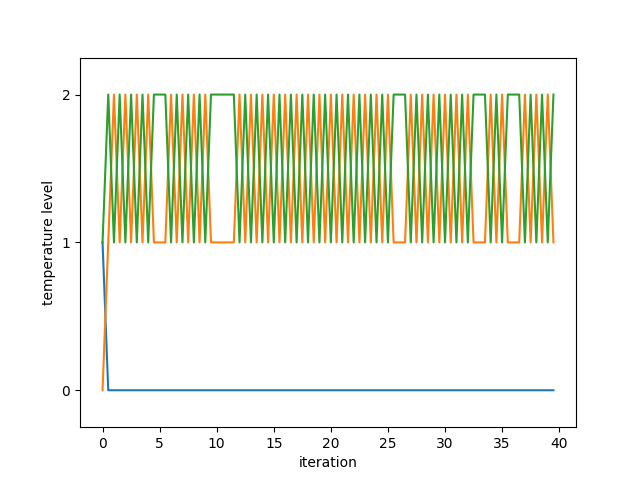

In [22]:
# we'll plot the swap index of the first chain;
# first, add the missing swap index back in for plotting
swap_index = temperature_swaps['swap_index'][:, 1, :]
lastindex = numpy.repeat(2, sampler.niterations).astype(int)
lastindex[swap_index[1, :] != 1] = 1
swap_index = numpy.stack([swap_index[0,:], swap_index[1,:], lastindex])

fig, ax = pyplot.subplots()
# we'll just plot the first 40 iterations
pltiters = 40
x = numpy.array([[ii, ii+0.5] for ii in range(pltiters)]).flatten()
for tk in range(sampler.ntemps):
    y = numpy.array([[swap_index[tk, ii], tk] for ii in range(pltiters)]).flatten()
    ax.plot(x, y, color='C{}'.format(tk))
#ax.legend()
ax.set_ylim(-0.25, 2.25)
ax.set_yticks([0, 1, 2])
ax.set_xlabel('iteration')
ax.set_ylabel('temperature level')
fig.show()

We see that the first and second level are swapping on nearly every iteration, but coldest barely swaps at all. This suggests that our temperature ladder spacing was too large. Let's check the acceptance ratios.

<IPython.core.display.Javascript object>


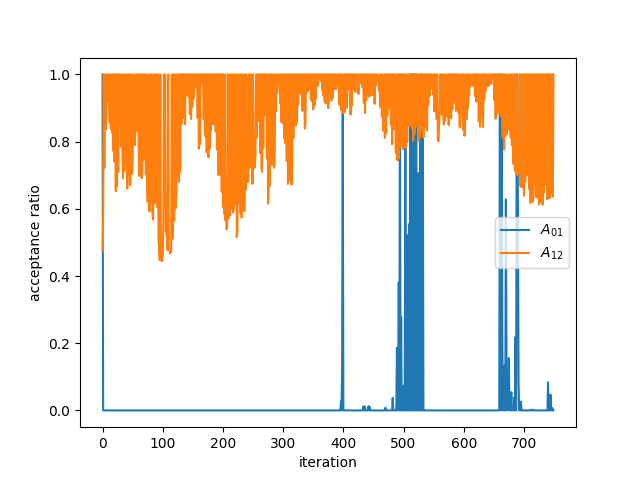

In [23]:
fig, ax = pyplot.subplots()
for tk in range(sampler.ntemps-1):
    # cap acceptance ratio at 1
    ar = temperature_swaps['acceptance_ratio'][tk, 1, :].copy()
    ar[ar > 1] = 1.
    ax.plot(ar, label='$A_{%i %i}$'%(tk, tk+1))
ax.legend()
ax.set_xlabel('iteration')
ax.set_ylabel('acceptance ratio')
fig.show()

## Create an animation of the results

To visualize the results, we'll create an animation showing how the chains evolved. We'll do this by plotting one point for each chain, with each frame in the animation representing a single iteration.

***Note: To keep file size down, the animation has not been created for the version of this notebook uploaded to the repository.***

In [ ]:
from matplotlib import animation

In [ ]:
# Prepare an array to create a density map showing the shape of the model posterior
npts = 100
xmean, ymean = model.likelihood_dist.mean
xsig = model.likelihood_dist.cov[0,0]**0.5
ysig = model.likelihood_dist.cov[1,1]**0.5
X, Y = numpy.mgrid[xmean-3*xsig:xmean+3*xsig:complex(0, npts),
                   ymean-3*ysig:ymean+3*ysig:complex(0, npts)]
Z = numpy.zeros(X.shape)
for ii in range(Z.shape[0]):
    for jj in range(Z.shape[1]):
        logl, logp = model(x=X[ii,jj], y=Y[ii,jj])
        Z[ii, jj] = numpy.exp(logl+logp)

In [ ]:
# we'll just animate the first 200 iterations; change this to
# nframes = xdata.shape[1] if you want to see all iterations
nframes = 200

In [ ]:
fig, ax = pyplot.subplots()

positions = sampler.positions[0,...]
xdata = positions['x']
ydata = positions['y']

# Plot contours showing the shape of the true posterior density
#ax.contour(X, Y, Z, 2, colors='k', linewidths=1, linestyles='dashed', zorder=-2)
ax.imshow(numpy.rot90(Z), extent=[X.min(), X.max(), Y.min(), Y.max()],
          aspect='auto', cmap='binary', zorder=-3)

# Put an x at the maximum posterior point
ax.scatter(model.mean[0], model.mean[1], marker='x', color='w', s=10, zorder=-2)
ax.set_xlabel('x')
ax.set_ylabel('y')
# create the scatter points
ptsize = 60

# we'll include the last bufferlen number of steps a chain visited, having the size and transparency
# exponentially damped with each new frame
bufferlen = 16
alphas = numpy.exp(-4*(numpy.arange(bufferlen))/float(bufferlen))
sizes = ptsize * alphas
#colors = numpy.array(['C{}'.format(ii) for ii in range(nchains)])
colors = numpy.arange(nchains)
plts = [ax.scatter(xdata[:, bufferlen-ii-1], ydata[:, bufferlen-ii-1], c=colors, s=sizes[ii],
                   edgecolors='w', linewidths=0.5,
                   alpha=alphas[ii], zorder=bufferlen-ii, marker='s' if ii==0 else 'o', cmap='jet')
        for ii in range(bufferlen)]
# put a + showing the average of the chain positions at the current iteration
meanplt = ax.scatter(xdata[:,0].mean(), ydata[:,0].mean(), marker='P', c='w', edgecolors='k', linewidths=0.5,
                     zorder=bufferlen+1)

# add some text giving the iteration
itertxt = 'Iteration {}'
txt = ax.annotate(itertxt.format(1), (0.03, 0.94), xycoords='axes fraction')

def animate(ii):
    txt.set_text(itertxt.format(ii+1))
    for jj,plt in enumerate(plts):
        plt.set_offsets(numpy.array([xdata[:, max(ii-jj, 0)], ydata[:, max(ii-jj, 0)]]).T)
    meanplt.set_offsets([xdata[:,ii].mean(), ydata[:,ii].mean()])
    # zoom in as it narrows on the result
    istart = max(ii-bufferlen, 0)
    # smooth it out a bit
    xmin = numpy.array([xdata[:, max(istart-kk, 0):].min() for kk in range(50)]).mean()
    xmax = numpy.array([xdata[:, max(istart-kk, 0):].max() for kk in range(50)]).mean()
    ymin = numpy.array([ydata[:, max(istart-kk, 0):].min() for kk in range(50)]).mean()
    ymax = numpy.array([ydata[:, max(istart-kk, 0):].max() for kk in range(50)]).mean()
    ax.set_xlim((1.1 if xmin < 1 else 0.9)*xmin, (0.9 if xmax < 1 else 1.1)*xmax)
    ax.set_ylim((1.1 if ymin < 1 else 0.9)*ymin, (0.9 if ymax < 1 else 1.1)*ymax)


ani = animation.FuncAnimation(fig, animate, frames=nframes, interval=160, blit=True)

Save the animation:

In [ ]:
ani.save('pt_chain_animation.mp4')

The result:

In [ ]:
%%HTML
<video width="640" height="480" controls>
  <source src="pt_chain_animation.mp4" type="video/mp4">
</video>